In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report,confusion_matrix,f1_score
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## SASTRAWI EXMPL CODE

In [3]:
# import Sastrawi package
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
stemmer = StemmerFactory().create_stemmer()
sentence = 'Perekonomian Indonesia sedang dalam pertumbuhan/yang membanggakan'
stemmer.stem(sentence)

'ekonomi indonesia sedang dalam tumbuh yang bangga'

In [4]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
kalimat = 'Dengan Menggunakan Python dan Library Sastrawi saya dapat melakukan proses Stopword Removal'
swdel = StopWordRemoverFactory().create_stop_word_remover()
swdel.remove(kalimat)

'Dengan Menggunakan Python Library Sastrawi dapat melakukan proses Stopword Removal'

## TYPO CORRECTION
from http://www.yasirblog.com/2017/07/spell-checker-pengecekan-ejaan-untuk-deteksi-perbaikan-typo-bahasa-indonesia.html

In [106]:
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('katadasar.txt').read()))

def P(word, N=sum(WORDS.values())): 
    # "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    # "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    # "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    # "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    # "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)] # [('', 'kemarin'), ('k', 'emarin'), ('ke', 'marin'), dst]
    deletes    = [L + R[1:]               for L, R in splits if R] # ['emarin', 'kmarin', 'kearin', dst]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1] # ['ekmarin', 'kmearin', 'keamrin', dst]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters] # ['aemarin', 'bemarin', 'cemarin', dst]
    inserts    = [L + c + R               for L, R in splits for c in letters] # ['akemarin', 'bkemarin', 'ckemarin', dst]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    # "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))
#check typo dalam kalimat
def checktypo(string):
    string = str(string)
    listword = string.split()
    index=0
    for word in string.split():
        listword[index]=correction(word)
        index = index+1
    newstr = ' '.join(word for word in listword)
    return (newstr)

kata = 'mkan'
print('kata typo : ', kata)
print('koreksi : ', correction(kata))

kata typo :  mkan
koreksi :  akan


In [108]:
checktypo('karna orang lebih suka menyumbang')

'karena orang lebih suka menyumbang'

### Try KBBI

In [48]:
from kbbi import KBBI
string = 'asdf'
try:
    print(KBBI(string))
except:
    print('not in kbbi')

not in kbbi


### START DATA EXPLORATION

In [110]:
data=pd.read_csv('UKARA DATA B/Data B/data_train_B.csv')
print(len(data))
print(data.groupby(data['LABEL']).count())
data.head()

305
       RES_ID  RESPONSE
LABEL                  
0         137       137
1         168       168


,RES_ID,RESPONSE,LABEL
0,TRB1,Karena orang berpikir bahwa jika disumbangkan ...,1
1,TRB2,Pakaian awet adalah alternatif terhadap Fast F...,0
2,TRB3,karna orang lebih suka menyumbang,1
3,TRB4,karana harga nya terjangkau dan pas.,0
4,TRB5,kerena harganya mahal .,0


In [111]:
data.dtypes

RES_ID      object
RESPONSE    object
LABEL        int64
dtype: object

Text(0.5, 1.0, 'count label')

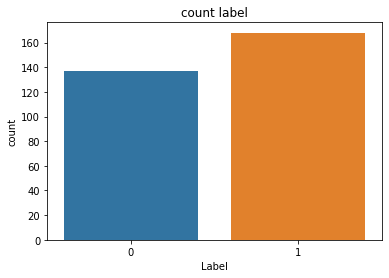

In [112]:
sns.countplot(data['LABEL'])
plt.xlabel('Label')
plt.title('count label')

There are 29991 words in the combination of all review.


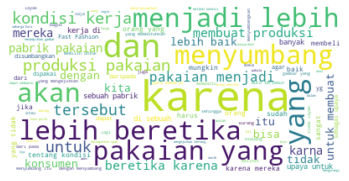

In [113]:
text = " ".join(review for review in data.RESPONSE)
print ("There are {} words in the combination of all review.".format(len(text)))
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [114]:
from collections import Counter
cnt = Counter()
for text in data["RESPONSE"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('karena', 172),
 ('yang', 167),
 ('pakaian', 149),
 ('lebih', 134),
 ('untuk', 102),
 ('dan', 94),
 ('menyumbang', 65),
 ('kondisi', 65),
 ('di', 65),
 ('produksi', 60)]

## PREP DATA

In [115]:
data['processed'] = data['RESPONSE'].str.lower()
data.head()

,RES_ID,RESPONSE,LABEL,processed
0,TRB1,Karena orang berpikir bahwa jika disumbangkan ...,1,karena orang berpikir bahwa jika disumbangkan ...
1,TRB2,Pakaian awet adalah alternatif terhadap Fast F...,0,pakaian awet adalah alternatif terhadap fast f...
2,TRB3,karna orang lebih suka menyumbang,1,karna orang lebih suka menyumbang
3,TRB4,karana harga nya terjangkau dan pas.,0,karana harga nya terjangkau dan pas.
4,TRB5,kerena harganya mahal .,0,kerena harganya mahal .


In [116]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

stemmer = StemmerFactory().create_stemmer()
swdel = StopWordRemoverFactory().create_stop_word_remover()

#insert typos correction here
tmp = 0 #row index
for row in data['processed']:
    data['processed'][tmp] = checktypo(row)
    tmp = tmp+1

tmp = 0 #row index
for row in data['processed']:
    data['processed'][tmp] = stemmer.stem(row)
    tmp = tmp+1
    
tmp = 0 #row index
for row in data['processed']:
    data['processed'][tmp] = swdel.remove(row)
    tmp = tmp+1
    
data.head()

C:\Users\iykmuham0008\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\iykmuham0008\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\iykmuham0008\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

,RES_ID,RESPONSE,LABEL,processed
0,TRB1,Karena orang berpikir bahwa jika disumbangkan ...,1,orang pikir jika sumbang buat produksi pakai j...
1,TRB2,Pakaian awet adalah alternatif terhadap Fast F...,0,pakai awet alternatif hadap fast fashion pakai...
2,TRB3,karna orang lebih suka menyumbang,1,orang lebih suka sumbang
3,TRB4,karana harga nya terjangkau dan pas.,0,harga nya jangkau pas
4,TRB5,kerena harganya mahal .,0,harga mahal


In [117]:
with pd.option_context('display.max_rows', 999,'display.max_colwidth', 999):
    print(data['processed'].head())
    print(data['processed'].tail())
    #print(data['processed'])

0                                                                                                                                                                                      orang pikir jika sumbang buat produksi pakai jadi lebih etika
1    pakai awet alternatif hadap fast fashion pakai awet lebih mahal biaya produksi harga beli karena pakai buat tahan lebih lama buang buat jadi lebih sedikit bagai konsumen tolak tren fast fashion beli pakai buang lebih awet buat sesuai etika
2                                                                                                                                                                                                                           orang lebih suka sumbang
3                                                                                                                                                                                                                              harga nya jangkau pas
4                   

In [118]:
from collections import Counter
cnt = Counter()
for text in data["processed"].values:
    for word in text.split():
        cnt[word] += 1
        
print(cnt.most_common(999))

[('buang', 221), ('pakai', 214), ('lebih', 142), ('sumbang', 123), ('etika', 89), ('kerja', 87), ('depan', 76), ('buat', 74), ('produksi', 68), ('jadi', 66), ('kondisi', 66), ('pabrik', 63), ('orang', 57), ('baik', 55), ('sebut', 52), ('buah', 45), ('konsumen', 43), ('banyak', 34), ('beli', 31), ('mereka', 31), ('akan', 30), ('lihat', 26), ('upaya', 26), ('layak', 25), ('bagai', 24), ('2', 23), ('euro', 23), ('pilih', 22), ('kaus', 22), ('fashion', 21), ('harga', 21), ('untuk', 21), ('bantu', 20), ('butuh', 20), ('mungkin', 17), ('pahala', 17), ('kurang', 17), ('beri', 17), ('tidak', 17), ('sangat', 16), ('sampah', 16), ('gambar', 15), ('fast', 14), ('yg', 14), ('kejut', 14), ('dari', 13), ('turut', 13), ('manfaat', 12), ('tampil', 12), ('jika', 11), ('awet', 11), ('kita', 11), ('hadap', 10), ('lama', 10), ('bisa', 10), ('bagus', 10), ('rasa', 10), ('di', 10), ('upah', 10), ('kasihan', 9), ('sama', 9), ('lingkung', 9), ('cara', 9), ('putih', 9), ('tahan', 8), ('sesuai', 8), ('baju', 8)

In [120]:
checktypo('kerena harganya mahal')

'karena harganya mahal'

## MODELING without processing

In [121]:
from sklearn.model_selection import train_test_split
xtr,xts,ytr,yts=train_test_split(data['RESPONSE'].apply(lambda x:x.lower()),data['LABEL'],
    stratify=data['LABEL'],
    test_size=0.2, 
    random_state=420)
print(xtr.shape)
print(xts.shape)

(244,)
(61,)


In [122]:
test=pd.read_csv('UKARA DATA A/Data A/data_dev_A.csv')
#print(np.array(test['RESPONSE']).reshape(len(test['RESPONSE']),1))

In [123]:

multinomialPipeline = Pipeline([
    ('cv',CountVectorizer()),
    ('classifier',MultinomialNB())
])
multinomialPipeline.fit(xtr,ytr)
multinomialPrediksiTrain = multinomialPipeline.predict(xtr)
multinomialPrediksi = multinomialPipeline.predict(xts)
multinomialPrediksiDev = multinomialPipeline.predict(test['RESPONSE'].apply(lambda x:x.lower()))

In [124]:
complementPipeline = Pipeline([
    ('cv',CountVectorizer()),
    ('classifier',ComplementNB())
])
complementPipeline.fit(xtr,ytr)
complementPrediksiTrain = complementPipeline.predict(xtr)
complementPrediksi = complementPipeline.predict(xts)
complementPrediksiDev = complementPipeline.predict(test['RESPONSE'].apply(lambda x:x.lower()))

In [125]:
adaboostPipeline = Pipeline([
    ('cv',CountVectorizer()),
    ('classifier',AdaBoostClassifier())
])
adaboostPipeline.fit(xtr,ytr)
adaboostPrediksiTrain = adaboostPipeline.predict(xtr)
adaboostPrediksi = adaboostPipeline.predict(xts)
adaboostPrediksiDev = adaboostPipeline.predict(test['RESPONSE'].apply(lambda x:x.lower()))

In [126]:
print(multinomialPrediksi)
print("----------------------------------------------------")
print(complementPrediksi)

[1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 1 1
 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1]
----------------------------------------------------
[0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 1 1
 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1]


In [127]:
print('Dengan metode MultinomialNB, diperoleh: ')
print(classification_report(yts,multinomialPrediksi))
print('Skor f1:',f1_score(yts,multinomialPrediksi))
print(confusion_matrix(yts,multinomialPrediksi))

Dengan metode MultinomialNB, diperoleh: 
              precision    recall  f1-score   support

           0       0.79      0.56      0.65        27
           1       0.71      0.88      0.79        34

    accuracy                           0.74        61
   macro avg       0.75      0.72      0.72        61
weighted avg       0.75      0.74      0.73        61

Skor f1: 0.7894736842105262
[[15 12]
 [ 4 30]]


In [128]:
print('Dengan metode ComplementNB, diperoleh: ')
# print(classification_report(ytr,complementPrediksiTrain))
print(classification_report(yts,complementPrediksi))
print('Skor f1:',f1_score(yts,complementPrediksi))
print(confusion_matrix(yts,complementPrediksi))

Dengan metode ComplementNB, diperoleh: 
              precision    recall  f1-score   support

           0       0.81      0.63      0.71        27
           1       0.75      0.88      0.81        34

    accuracy                           0.77        61
   macro avg       0.78      0.76      0.76        61
weighted avg       0.78      0.77      0.77        61

Skor f1: 0.8108108108108107
[[17 10]
 [ 4 30]]


In [129]:
print('Dengan metode AdaBoostClassifier, diperoleh: ')
# print(classification_report(ytr,adaboostPrediksiTrain))
print(classification_report(yts,adaboostPrediksi))
print('Skor f1:',f1_score(yts,adaboostPrediksi))
print(confusion_matrix(yts,complementPrediksi))

Dengan metode AdaBoostClassifier, diperoleh: 
              precision    recall  f1-score   support

           0       0.63      0.70      0.67        27
           1       0.74      0.68      0.71        34

    accuracy                           0.69        61
   macro avg       0.69      0.69      0.69        61
weighted avg       0.69      0.69      0.69        61

Skor f1: 0.7076923076923077
[[17 10]
 [ 4 30]]


## MODELING with processing

In [130]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(data['processed'].apply(lambda x:x.lower()),data['LABEL'],
    stratify=data['LABEL'],
    test_size=0.2, 
    random_state=420)
print(xtrain.shape)
print(xtest.shape)

(244,)
(61,)


In [131]:

multinomialPipeline = Pipeline([
    ('cv',CountVectorizer()),
    ('classifier',MultinomialNB())
])
multinomialPipeline.fit(xtrain,ytrain)
multinomialPrediksiTrain = multinomialPipeline.predict(xtrain)
multinomialPrediksi = multinomialPipeline.predict(xtest)
#multinomialPrediksiDev = multinomialPipeline.predict(test['RESPONSE'].apply(lambda x:x.lower()))

In [132]:
complementPipeline = Pipeline([
    ('cv',CountVectorizer()),
    ('classifier',ComplementNB())
])
complementPipeline.fit(xtrain,ytrain)
complementPrediksiTrain = complementPipeline.predict(xtrain)
complementPrediksi = complementPipeline.predict(xtest)
#complementPrediksiDev = complementPipeline.predict(test['RESPONSE'].apply(lambda x:x.lower()))

In [133]:
adaboostPipeline = Pipeline([
    ('cv',CountVectorizer()),
    ('classifier',AdaBoostClassifier())
])
adaboostPipeline.fit(xtrain,ytrain)
adaboostPrediksiTrain = adaboostPipeline.predict(xtrain)
adaboostPrediksi = adaboostPipeline.predict(xtest)
#adaboostPrediksiDev = adaboostPipeline.predict(test['RESPONSE'].apply(lambda x:x.lower()))

In [134]:
print(multinomialPrediksi)
print("----------------------------------------------------")
print(complementPrediksi)

[1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1
 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
----------------------------------------------------
[1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1
 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1]


In [135]:
print(' MultinomialNB + wordstop + stemming, diperoleh: ')
print(classification_report(ytest,multinomialPrediksi))
print('Skor f1:',f1_score(ytest,multinomialPrediksi))
print(confusion_matrix(ytest,multinomialPrediksi))

 MultinomialNB + wordstop + stemming, diperoleh: 
              precision    recall  f1-score   support

           0       0.77      0.37      0.50        27
           1       0.65      0.91      0.76        34

    accuracy                           0.67        61
   macro avg       0.71      0.64      0.63        61
weighted avg       0.70      0.67      0.64        61

Skor f1: 0.7560975609756098
[[10 17]
 [ 3 31]]


In [136]:
print('ComplementNB + wordstop + stemming, diperoleh: ')
# print(classification_report(ytr,complementPrediksiTrain))
print(classification_report(ytest,complementPrediksi))
print('Skor f1:',f1_score(ytest,complementPrediksi))
print(confusion_matrix(ytest,complementPrediksi))

ComplementNB + wordstop + stemming, diperoleh: 
              precision    recall  f1-score   support

           0       0.69      0.41      0.51        27
           1       0.64      0.85      0.73        34

    accuracy                           0.66        61
   macro avg       0.67      0.63      0.62        61
weighted avg       0.66      0.66      0.64        61

Skor f1: 0.7341772151898734
[[11 16]
 [ 5 29]]


In [137]:
print(' AdaBoostClassifier + wordstop + stemming, diperoleh: ')
# print(classification_report(ytr,adaboostPrediksiTrain))
print(classification_report(ytest,adaboostPrediksi))
print('Skor f1:',f1_score(ytest,adaboostPrediksi))
print(confusion_matrix(ytest,complementPrediksi))

 AdaBoostClassifier + wordstop + stemming, diperoleh: 
              precision    recall  f1-score   support

           0       0.77      0.63      0.69        27
           1       0.74      0.85      0.79        34

    accuracy                           0.75        61
   macro avg       0.76      0.74      0.74        61
weighted avg       0.76      0.75      0.75        61

Skor f1: 0.7945205479452054
[[11 16]
 [ 5 29]]
